# Panagiotis Karamitopoulos
# Poverty Prediction Project

# Import Libraries

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import zipfile
import seaborn as sns


In [ ]:
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/Poverty Prediction Project/Data"

Mounted at /content/drive


#1. Data Preprocessing

#1.1 Load Data

In [ ]:
x_train = pd.read_csv(f"{BASE_DIR}/train_hh_features.csv")
y_train = pd.read_csv(f"{BASE_DIR}/train_hh_gt.csv")
x_test_official = pd.read_csv(f"{BASE_DIR}/test_hh_features.csv")

x_train.shape, y_train.shape, x_test_official.shape,

((104234, 88), (104234, 3), (103023, 88))

In [ ]:
x_train.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

In [ ]:
x_test_official.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

In [ ]:
y_train.columns

Index(['survey_id', 'hhid', 'cons_ppp17'], dtype='object')

#1.2 Merge Features with Labels

In [ ]:
df_train = x_train.merge(y_train, on=['hhid', 'survey_id'], how='inner')
df_train.shape


(104234, 89)

Τα αρχεία train_hh_features.csv και train_hh_gt.csv συγχωνεύονται με βάση το hhid, δηλαδή το id της οικογένειας, καθώς και το survey_id, δηλαδή το id της έρευνας. Αυτό γίνεται καθώς η συγχώνευση με βάση μόνο το hhid ενδεχομένως να οδηγούσε σε λανθασμένες αντιστοιχίσεις, αν μια οικογένεια έχει συμμετάσχει σε δύο διαφορετικές έρευνες (π.χ. σε διαφορετικά έτη). Επιπλέον, τέθηκε how='inner', ώστε να διατηρούνται μόνο οι εγγραφές που υπάρχουν και στα δύο αρχεία (π.χ. αν μια οικογένεια υπάρχει μόνο στο 1ο αρχείο, αλλά όχι στο 2ο, τότε αυτήν η οικογένεια δεν θα διατηρηθεί στο συγχωνευμένο αρχείο, ισχύει και το αντίστροφο). Ως αποτέλεσμα, το νέο συγχωνευμένο σύνολο δεδομένων, περιλαμβάνει 104234 εγγραφές (οικογένειες) με 89 στήλες.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104234 entries, 0 to 104233
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   hhid               104234 non-null  int64  
 1   com                104234 non-null  int64  
 2   weight             104234 non-null  int64  
 3   strata             104234 non-null  int64  
 4   utl_exp_ppp17      104149 non-null  float64
 5   male               104234 non-null  object 
 6   hsize              104234 non-null  int64  
 7   num_children5      104234 non-null  int64  
 8   num_children10     104234 non-null  int64  
 9   num_children18     104234 non-null  int64  
 10  age                104234 non-null  int64  
 11  owner              104234 non-null  object 
 12  water              104234 non-null  object 
 13  toilet             104234 non-null  object 
 14  sewer              104234 non-null  object 
 15  elect              104234 non-null  object 
 16  wa

Το σύνολο δεδομένων περιλαμβάνει 104234 καταγραφές (σπίτια/οικογένειες) με 88 χαρακτηριστικά και τη μεταβλητή στόχο, την cons_ppp17.
Πιο συγκεκριμένα τα χαρακτηριστικά είναι τα εξής:
1) hhid -> Μοναδικός αναγνωριστικός κωδικός ενός σπιτιού/οικογένειας.
2) com -> Αναγνωριστικό μέλους της οικογένειας.
3) weight -> Δειγματοληπτικό βάρος της οικογένειας.
4) strata -> Μεταβλητή διαστρωμάτωσης.
5) utl_exp_ppp17 -> Δαπάνες για υπηρεσίες κοινής ωφέλειας (PPP17).
6) male -> Ο αρχηγός της οικογένειας είναι άνδρας.
7) hsize -> Αριθμός μελών της οικογένειας.
8) num_children5 -> Αριθμός παιδιών κάτω των 5 ετών της οικογένειας.
9) num_children10 -> Αριθμός παιδιών ηλικίας 5-10 ετών της οικογένειας.
10) num_children18 -> Αριθμός παιδιών ηλικίας 10-18 ετών της οικογένειας.
11) age -> Ηλικία του αρχηγού της οικογένειας.
12) owner -> Ιδιοκτήτης κατοικίας;
13) water -> Η κατοικία έχει πρόσβαση στο σύστημα ύδρευσης;
14) toilet -> Υπάρχουν τουαλέτες στην κατοικία;
15) sewer -> Οι τουαλέτες συνδέονται με το αποχετευτικό σύστημα;
16) elect -> Η κατοικία έχει πρόσβαση σε ηλεκτρικό ρεύμα;
17) water_source -> Πηγές πόσιμου νερού.
18) sanitation_source -> Κύρια πηγή αποχέτευσης.
19) dweltyp -> Τύπος κατοικίας.
20) num_adult_female -> Αριθμός ενήλικων γυναικών ηλικίας 18-69 ετών στην οικογένεια.
21) num_adult_male -> Αριθμός ενήλικων ανδρών ηλικίας 18-69 ετών στην οικογένεια.
22) num_elderly -> Αριθμός ηλικιωμένων ηλικίας 70+ ετών στην οικογένεια.
23) employed -> Ο αρχηγός της οικογένειας είναι εργαζόμενος.
24) sworkershh -> Ποσοστό ενηλίκων που εργάζονται στην οικογένεια.
25) share_secondary -> Ποσοστό ενηλίκων αποφοίτων δευτεροβάθμιας εκπαίδευσης στην οικογένεια.
26) educ_max -> Υψηλότερο επίπεδο εκπαίδευσης στην οικογένεια.
27) sfworkershh -> Ποσοστό των ενήλικων εργαζομένων σε επίσημη απασχόληση.
28) any_nonagric -> Κάθε μέλος του νοικοκυριού που εργάζεται σε μη γεωργικό τομέα.
29) sector1d -> Τομέας απασχόλησης του αρχηγού της οικογένειας.
30) region1 -> Γεωγραφικό χαρακτηριστικό.
31) ... -> Γεωγραφικό χαρακτηριστικό.
36) region7 -> Γεωγραφικό χαρακτηριστικό.   
37) urban -> Αστικός δείκτης/Γεωγραφικό χαρακτηριστικό.
38) consumed100 -> Ψωμί - Χαρακτηριστικό σχετικό με την κατανάλωση τροφίμων.
39) ... -> Χαρακτηριστικό σχετικό με την κατανάλωση τροφίμων.
87) consumed5000 -> Άλλα τρόφιμα που καταναλώνονται - Χαρακτηριστικό σχετικό με την κατανάλωση τροφίμων.
88) survey_id -> Αναγνωριστικό της έρευνας.

Τέλος, η μεταβλητή στόχος, cons_ppp17, αφορά τις καθημερινές δαπάνες ανά κάτοικο/μέλος (PPP17).

#2. Data Analysis

# 2.1 Create Input and Target Variables


In [ ]:
x = df_train.drop(columns=['hhid', 'survey_id', 'com', 'cons_ppp17'])
y = df_train['cons_ppp17']
x.shape, y.shape

((104234, 85), (104234,))

Αφαίρεση των ids (hhid, survey_id και com), καθώς τα χαρακτηριστικά αυτά είναι περιττά και δεν έχουν κάποια συσχέτιση με τον στόχο. Τέλος, αφαρείται και η μεταβλητή στόχος, cons_ppp17.

#2.2 Describe and Plot Target

In [ ]:
y.describe()

,cons_ppp17
count,104234.000000
mean,11.555229
std,10.034225
min,0.359563
25%,5.439294
50%,8.774002
75%,14.216931
max,236.115680


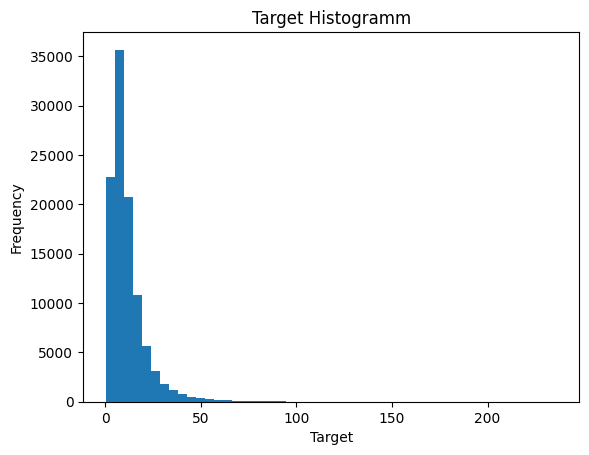

In [ ]:
plt.hist(y, bins=50)
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.title("Target Histogramm")
plt.show()

Η κατανομή που ακολουθεί η μεταβλητή στόχος μοιάζει με την εκθετική κατανομή, καθώς παρουσιάζει έντονη ασυμμετρία. Επιπλέον, σε συνδιασμό με την ύπαρξη ακραίων τιμών, η μοντελοποίηση καθίσταται πιο απαιτητική.


#2.3 Feature Importance - Correlations

In [ ]:
categorical_features = x.select_dtypes(include=['object']).columns
numerical_features = x.select_dtypes(include=['int64','float64']).columns

categorical_features, numerical_features, categorical_features.shape, numerical_features.shape

(Index(['male', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source',
        'sanitation_source', 'dweltyp', 'employed', 'educ_max', 'any_nonagric',
        'sector1d', 'urban', 'consumed100', 'consumed200', 'consumed300',
        'consumed400', 'consumed500', 'consumed600', 'consumed700',
        'consumed800', 'consumed900', 'consumed1000', 'consumed1100',
        'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500',
        'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900',
        'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300',
        'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700',
        'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100',
        'consumed3200', 'consumed3300', 'consumed3400', 'consumed3500',
        'consumed3600', 'consumed3700', 'consumed3800', 'consumed3900',
        'consumed4000', 'consumed4100', 'consumed4200', 'consumed4300',
        'consumed4400', 'consumed4500', 'consumed4600'

In [ ]:
correlations = x[numerical_features].corrwith(y).sort_values(ascending=False)
print("Highest positive correlations with target:")
print(correlations.head(5))
print("\nHighest negative correlations with target:")
print(correlations.tail(5))

Highest positive correlations with target:
utl_exp_ppp17    0.445324
sfworkershh      0.369261
region7          0.300099
region1          0.129630
region2          0.064078
dtype: float64

Highest negative correlations with target:
num_children10   -0.203503
num_children18   -0.221311
hsize            -0.272773
region5          -0.309193
strata           -0.445995
dtype: float64


Παρατηρείται ότι οι μεταβλητές  utl_exp_ppp17 (δαπάνες για υπηρεσίες κοινής ωφέλειας) και sfworkershh (ποσοστό των ενηλίκων εργαζομένων σε επίσημη απασχόληση) έχουν τη μεγαλύτερη θετική συσχέτιση με τον στόχο. Αυτό σημαίνει ότι όσο αυξάνονται οι εν λόγω μεταβλητές, αυξάνονται και οι  καθημερινές δαπάνες ανά μέλος της οικογένειας (στόχος). Από την άλλη πλευρά, οι μεταβλητές strata (χαρακτηριστικό διαστρωμάτωσης) και region5 (γεωγραφικό χαρακτηριστικό) παρουσιάζουν την υψηλότερη αρνητική συσχέτιση με τον στόχο.


#2.4 Missing Values

In [ ]:
missing = df_train.isna().mean().sort_values(ascending=False)
missing.head(60)

,0
sector1d,0.135551
dweltyp,0.011570
utl_exp_ppp17,0.000815
consumed5000,0.000633
consumed4900,0.000537
consumed4800,0.000537
consumed4600,0.000537
consumed4500,0.000518
consumed4400,0.000499
consumed4300,0.000499


Παρατηρείται ότι υπάρχουν αρκετά χαρακτηριστικά (56) με ελλιπείς τιμές.

#2.4.1 Numerical Ιmputation with Μedian


In [ ]:
num_imputer = SimpleImputer(strategy='median')
x_num = num_imputer.fit_transform(x[numerical_features])

#2.4.2 Categorical Ιmputation with Mode

In [ ]:
cat_imputer = SimpleImputer(strategy='most_frequent')
x_cat = cat_imputer.fit_transform(x[categorical_features])

Κατά την προεπεξεργασία των δεδομένων οι ελλιπείς τιμές των  αριθμητικών χαρακτηριστικών συμπληρώθηκαν με τη διάμεσο γιατί είναι πιο ανθεκτική στις ακραίες τιμές, ενώ οι ελλιπείς τιμές των κατηγορικών χαρακτηριστικών συμπληρώθηκαν με τη πιο συχνή τιμή, καθώς αποτελεί το πιο πιθανό αντιπροσωπευτικό δείγμα για τις τιμές που λείπουν.

#2.5 Encode Categorical Features

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
x_cat_encoded = encoder.fit_transform(x_cat)

#2.6 Merge Numerical and Categorical Features



In [ ]:
x_processed = np.hstack([x_num, x_cat_encoded])
x_processed.shape

(104234, 181)

#2.7 Split Dataset to Train-Test

In [ ]:
seed = 42
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=test_size, random_state=seed)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((83387, 181), (83387,), (20847, 181), (20847,))

#2.8 StandardScaling Normalization

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Επιπλέον, τα κατηγορικά χαρακτηριστικά κωδικοποιήθηκαν ώστε να μετατραπούν σε κατάλληλη μορφή για τους αλγορίθμους μάθησης. Πιο συγκεκριμένα, εφαρμόσθηκε κωδικοποίηση onehot, ούτως ώστε να αποφευχθεί η εισαγωγή λανθασμένης ιεραρχίας και να αντιμετωπίζεται ισότιμα κάθε κατηγορία.

Έπειτα, το σύνολο δεδομένων διαχωρίστηκε στα υποσύνολα x_train, x_test, y_train και y_test με αναλογία 80% για εκπαίδευση και 20% για έλεγχο. Μετά τον διαχωρισμό, εφαρμόσθηκε κανονικοποίηση standard scaling, η οποία μετατρέπει όλα τα χαρακτηριστικά έτσι ώστε να έχουν μέση τιμή 0 και τυπική απόκλιση 1. Αξίζει να σημειωθεί, ότι οι παράμετροι της κανονικοποίησης υπολογίστηκαν αποκλειστικά στο υποσύνολο εκπαίδευσης και στη συνέχεια εφαρμόστηκαν στο υποσύνολο ελέγχου για την αποφυγή διαρροής δεδομένων. Με αυτή τη μέθοδο κανονικοποίησης, εμποδίζεται η κυριαρχία των μεταβλητών με μεγάλες τιμές και επιτυγχάνεται ταχύτερη σύγκλιση των αλγορίθμων ιδίως σε εφαρμογές βαθιάς μάθησης.


#3. Machine Learning and Deep Learning Models

#3.1 RMSE Function

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Ως μετρική αξιολόγησης των μοντέλων επιλέχθηκε η Τετραγωνική Ρίζα του Μέσου Τετραγωνικού Σφάλματος (Root Mean Squared Error (RMSE)), καθώς τιμωρεί σε μεγαλύτερο βαθμό τα μεγάλα σφάλματα πρόβλεψης. Με αυτόν τον τρόπο το μοντέλο αποφεύγει ακραίες εσφαλμένες προβλέψεις. Επιπλέον, η χρήση του RMSE καθιστά το μέγεθος του σφάλματος περισσότερο κατανοητό, καθώς εκφράζεται στις ίδιες μονάδες μέτρησης με τη μεταβλητή στόχο.

#3.2 Tuning and Evaluation of a Linear Ridge Regression Model


In [ ]:
alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 1, 10, 100]
ridge = Ridge()
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_ridge = GridSearchCV(ridge, param_grid={'alpha': alphas}, scoring='neg_root_mean_squared_error', cv=cv_strategy, n_jobs=-1)
grid_ridge.fit(x_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
y_test_ridge_pred = best_ridge.predict(x_test_scaled)
test_ridge_rmse = rmse(y_test, y_test_ridge_pred)

print(f"Best alpha: {grid_ridge.best_params_['alpha']}")
print(f"Cross - Validation RMSE: {-grid_ridge.best_score_:.4f}")
print(f"Test - Set RMSE: {test_ridge_rmse:.4f}")

Best alpha: 0.3
Cross - Validation RMSE: 6.8607
Test - Set RMSE: 6.8533


Αρχικά, αποφασίστηκε να εκπαιδευτεί ένα απλό γραμμικό μοντέλο ως μοντέλο αναφοράς. Πιο συγκεκριμένα, επιλέχθηκε το μοντέλο Ridge (L2 norm) regression, καθώς  διαχειρίζεται καλύτερα τα πολλά χαρακτηριστικά που δημιουργούνται μετά την κωδικοποίηση onehot. Το μοντέλο αυτό διατηρεί όλα τα χαρακτηριστικά μειώνοντας απλά την επίδρασή (βάρη) τους, σε αντίθεση με το μοντέλο Lasso (L1 norm) που μηδενίζει κάποια βάρη. Με αυτόν τον τρόπο συντελούν στην πρόβλεψη της μεταβλητής στόχου ακόμα και χαρακτηριστικά που φέρουν λιγότερο χρήσιμη πληροφορία.

Για την εύρεση της καλύτερης παραμέτρου ομαλοποίησης (alpha), χρησιμοποιήθηκε η μέθοδος GridSearchCV με 5-fold cross-validation. Επιπλέον, πριν από κάθε δοκιμή τα δεδομένα ανακατευόταν τυχαία (shuffle=True), ώστε το μοντέλο να μην επηρεάζεται από τη σειρά των δεδομένων. Παράλληλα, τέθηκε το random state ίσο με 42, ώστε το ανακάτεμα των δεδομένων να είναι το ίδιο σε κάθε εκτέλεση του κώδικα και τα αποτελέσματα να παραμένουν σταθερά. Στη συνέχεια, αφού βρέθηκε η βέλτιστη τιμή του της παραμέτρου alpha (0.3), το βέλτιστο μοντέλο αξιολογήθηκε στο σύνολο ελέγχου.

Τέλος, προκύπτει ότι το RMSE στο σύνολο ελέγχου (6.8533) είναι ελαφρώς καλύτερο από το RMSE που υπολογίστηκε μέσω cross-validation (6.8607), συνεπώς το μοντέλο έχει πολύ καλή γενίκευση και δεν υπάρχουν ενδείξεις υπερπροσαρμογής.

#3.3 Hyperparameter Tuning and Evaluation of a Random Forest Regressor


In [ ]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10]
}

grid_rf = GridSearchCV(rf, param_grid_rf, scoring='neg_root_mean_squared_error', cv=cv_strategy, n_jobs=-1, verbose=1)
grid_rf.fit(x_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
y_test_rf_pred = best_rf.predict(x_test_scaled)
test_rf_rmse = rmse(y_test, y_test_rf_pred)

print(f"Best Random Forest Parameters: {grid_rf.best_params_}")
print(f"Cross - Validation RMSE: {-grid_rf.best_score_:.4f}")
print(f"Test - Set RMSE: {test_rf_rmse:.4f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Cross - Validation RMSE: 6.1909
Test - Set RMSE: 6.1013


param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10]
}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Cross - Validation RMSE: 6.1909
Test - Set RMSE: 6.1013

In [ ]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 15],
    'min_samples_split': [2, 5]
}
grid_rf1 = GridSearchCV(rf, param_grid_rf, scoring='neg_root_mean_squared_error',
    cv=cv_strategy, n_jobs=-1, verbose=1)
grid_rf1.fit(x_train_scaled, y_train)

best_rf1 = grid_rf1.best_estimator_
y_test_rf_pred1 = best_rf1.predict(x_test_scaled)
test_rf_rmse1 = rmse(y_test, y_test_rf_pred1)

print(f"Best Random Forest Parameters: {grid_rf1.best_params_}")
print(f"Cross - Validation RMSE: {-grid_rf1.best_score_:.4f}")
print(f"Test - Set RMSE: {test_rf_rmse1:.4f}")

param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 15],
    'min_samples_split': [2, 5]
}

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Cross - Validation RMSE: 6.1931
Test - Set RMSE: 6.1056

In [ ]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 8]
}
grid_rf2 = GridSearchCV(rf, param_grid_rf, scoring='neg_root_mean_squared_error',
    cv=cv_strategy, n_jobs=-1, verbose=1)
grid_rf2.fit(x_train_scaled, y_train)

best_rf2 = grid_rf2.best_estimator_
y_test_rf_pred2 = best_rf2.predict(x_test_scaled)
test_rf_rmse2 = rmse(y_test, y_test_rf_pred2)

print(f"Best Random Forest Parameters: {grid_rf2.best_params_}")
print(f"Cross - Validation RMSE: {-grid_rf2.best_score_:.4f}")
print(f"Test - Set RMSE: {test_rf_rmse2:.4f}")

param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 8]
}


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 8, 'n_estimators': 200}
Cross - Validation RMSE: 6.1912
Test - Set RMSE: 6.1009


In [ ]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 3],
    'min_samples_split': [8, 10]
}
grid_rf3 = GridSearchCV(rf, param_grid_rf, scoring='neg_root_mean_squared_error',
    cv=cv_strategy, n_jobs=-1, verbose=1)
grid_rf3.fit(x_train_scaled, y_train)

best_rf3 = grid_rf3.best_estimator_
y_test_rf_pred3 = best_rf3.predict(x_test_scaled)
test_rf_rmse3 = rmse(y_test, y_test_rf_pred3)

print(f"Best Random Forest Parameters: {grid_rf3.best_params_}")
print(f"Cross - Validation RMSE: {-grid_rf3.best_score_:.4f}")
print(f"Test - Set RMSE: {test_rf_rmse3:.4f}")

param_grid_rf = {'n_estimators': [200],
    'max_depth': [None, 3],
    'min_samples_split': [8, 10]
}

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Cross - Validation RMSE: 6.1909
Test - Set RMSE: 6.1013



Ως δεύτερο μοντέλο, επιλέχθηκε το Random Forest καθώς πρόκειται για ένα μοντέλο το οποίο βασίζεται σε πολλά δέντρα απόφασης και μπορεί να εντοπίσει σύνθετες μη γραμμικές σχέσεις στα δεδομένα. Για την εύρεση των καλύτερων τιμών των παραμέτρων, χρησιμοποιήθηκε και πάλι η μέθοδος GridSearchCV με 5-fold cross validation, shuffle=True και random_state=42. Λόγω των περιορισμένων πόρων του google colab, καθώς και της χρονοβόρας διαδικασίας εκπαίδευσης ο αριθμός των δέντρων (n_estimators) τέθηκε 200, ενώ οι παράμετροι που εξετάστηκαν είναι το μέγιστο βάθος τους (max_depth), καθώς και ο ελάχιστος αριθμός δειγμάτων που απαιτούνται για τον διαχωρισμό ενός κόμβου (min_samples_split). Στη συνέχεια, αφού βρέθηκαν οι βέλτιστες τιμές των παραμέτρων, το βέλτιστο μοντέλο αξιολογήθηκε στο σύνολο ελέγχου.

Τέλος, προκύπτει ότι το RMSE στο σύνολο ελέγχου (6.1013) είναι ελαφρώς καλύτερο από το RMSE που υπολογίστηκε μέσω cross-validation (6.1909), συνεπώς το μοντέλο έχει πολύ καλή γενίκευση και δεν υπάρχουν ενδείξεις υπερπροσαρμογής. Αξίζει να σημειωθεί, ότι το RMSE βελτιώθηκε κατά 11% σε σύγκριση με το γραμμικό μοντέλο Ridge. Συνεπώς, υπάρχουν σύνθετες μη γραμμικές σχέσεις στα δεδομένα που δεν μπορούσαν να εντοπιστούν από το γραμμικό μοντέλο.

#3.4 Hyperparameter Tuning and Evaluation of an XGBoost Model


In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid_xgb = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'subsample': [0.8, 0.9],
}

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(x_train_scaled, y_train)

best_xgb = grid_xgb.best_estimator_
y_test_pred_xgb = best_xgb.predict(x_test_scaled)
test_xgb_rmse = rmse(y_test, y_test_pred_xgb)

print(f"Best XGB Parameters: {grid_xgb.best_params_}")
print(f"Cross - Validation RMSE: {-grid_xgb.best_score_:.4f}")
print(f"Test - Set RMSE: {test_xgb_rmse:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best XGB Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Cross - Validation RMSE: 5.8929
Test - Set RMSE: 5.8066


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best XGB Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Cross - Validation RMSE: 5.8929
Test - Set RMSE: 5.8066

Ως τρίτο μοντέλο, επιλέχθηκε το Extreme Gradient Boost (XGBoost), καθώς είναι υπολογιστικά πιο αποδοτικό, διαχειρίζεται καλύτερα τη μνήμη και συνήθως επιτυγχάνει υψηλότερη ακρίβεια σε δομημένα δεδομένα. Σε αντίθεση με το Random Forest, το οποίο δημιουργεί ανεξάρτητα δέντρα, το XGBoost υλοποιεί διαδοχικά δέντρα, όπου το κάθε νέο δέντρο προσπαθεί να διορθώσει τα σφάλματα των προηγούμενων. Για την εύρεση των καλύτερων τιμών των παραμέτρων, χρησιμοποιήθηκε και πάλι η μέθοδος GridSearchCV με 5-fold cross-validation, shuffle=True και random_state=42. Πιο συγκεκριμένα, οι παράμετροι που εξετάστηκαν είναι ο αριθμός των δέντρων (n_estimators), το μέγιστο βάθος τους (max_depth), ο ρυθμός μάθησης (learning_rate) και το ποσοστό δεδομένων ανά δέντρο (subsample). Στη συνέχεια, αφού βρέθηκαν οι βέλτιστες τιμές των παραμέτρων, το βέλτιστο μοντέλο αξιολογήθηκε στο σύνολο ελέγχου.

Τέλος, προκύπτει ότι το RMSE στο σύνολο ελέγχου (5.8066) είναι ελαφρώς καλύτερο από το RMSE που υπολογίστηκε μέσω cross-validation (5.8929), συνεπώς το μοντέλο έχει πολύ καλή γενίκευση και δεν υπάρχουν ενδείξεις υπερπροσαρμογής. Αξίζει να σημειωθεί, ότι το RMSE βελτιώθηκε περεταίρω σε σύγκριση με το μοντέλο Random Forest. Συνεπώς, το XGBoost αποτελεί το καλύτερο μοντέλο μηχανικής μάθησης για αυτό το σύνολο δεδομένων.

#3.5 Create, Train and Evaluate an MLP Model

In [ ]:
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_scaled, y_train, test_size=0.1, random_state=42
)

dl_model = Sequential([
    Input(shape=(x_train_final.shape[1],)),

    Dense(512, activation=LeakyReLU(negative_slope=0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation=LeakyReLU(negative_slope=0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dl_model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = dl_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_test_dl_pred = dl_model.predict(x_test_scaled)
test_dl_rmse = rmse(y_test, y_test_dl_pred)
print(f"Test - Set RMSE: {test_dl_rmse:.4f}")

Epoch 1/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 60.8017 - root_mean_squared_error: 7.6782 - val_loss: 35.7770 - val_root_mean_squared_error: 5.9814 - learning_rate: 0.0010
Epoch 2/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 41.6277 - root_mean_squared_error: 6.4462 - val_loss: 37.6922 - val_root_mean_squared_error: 6.1394 - learning_rate: 0.0010
Epoch 3/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 38.2350 - root_mean_squared_error: 6.1821 - val_loss: 34.6102 - val_root_mean_squared_error: 5.8830 - learning_rate: 0.0010
Epoch 4/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 36.2624 - root_mean_squared_error: 6.0177 - val_loss: 34.7979 - val_root_mean_squared_error: 5.8990 - learning_rate: 0.0010
Epoch 5/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 35.7901 - root_mean_squared_error: 5.9803 - val_loss: 36.5091 - val_root_mean_squared_error: 6.0423 - learning_rate: 0.0010
Epoch 6/200
587/587 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 34.02

Ως μοντέλο βαθιάς μάθησης, επιλέχθηκε ένα τεχνητό νευρωνικό δίκτυο τύπου Multi – Layer Perceptron (MLP), έτσι ώστε να διερευνηθεί αν οι μη γραμμικοί μετασχηματισμοί που πραγματοποιούνται στα κρυφά επίπεδα (Hidden Layers) μπορούν να εντοπίσουν ακόμα πιο πολύπλοκες συσχετίσεις μεταξύ των χαρακτηριστικών.

Τα δεδομένα εκπαίδευσης διαχωρίζονται σε υποσύνολα εκπαίδευσης και επικύρωσης με αναλογία 90% - 10%, ώστε το μοντέλο να προσαρμόζει το ρυθμό μάθησης και να σταματά έγκαιρα αν ανιχνευθεί υπερπροσαρμογή. Για την υλοποίηση του νευρωνικού δικτύου επιλέχθηκε μια αρχιτεκτονική τεσσάρων κρυφών επιπέδων (Dense Layers). Πιο συγκεκριμένα:

Input Layer: Δέχεται ως είσοδο τα κανονικοποιημένα δεδομένα, συνεπώς ο αριθμός των νευρώνων ισούται με τον αριθμό των χαρακτηριστικών.

1st Hidden Layer: Είναι το μεγαλύτερο στρώμα, καθώς αποτελείται από 512 νευρώνες. Βασικός σκοπός του είναι να δημιουργήσει έναν πολύ μεγάλο αριθμό πιθανών σχέσεων μεταξύ των χαρακτηριστικών. Παράλληλα, στα δύο πρώτα στρώματα χρησιμοποιείται BatchNormalization, ώστε οι τιμές των νευρώνων να παραμένουν σε μια σταθερή κλίμακα. Αξίζει να σημειωθεί, ότι ως συνάρτηση ενεργοποίησης χρησιμοποιείται η LeakyRelu στα δύο πρώτα στρώματα,  διασφαλίζοντας ότι οι νευρώνες παραμένουν ενεργοί ακόμα και όταν οι είσοδοί τους πάρουν αρνητικές τιμές. Επιπλέον, η χρήση του Dropout (0.3) απενεργοποιεί τυχαία το 30% των νευρώνων σε κάθε κύκλο εκπαίδευσης. Με αυτόν τον τρόπο, το μοντέλο αναπτύσσει πολλαπλά μονοπάτια και δεν εξαρτάται από συγκεκριμένους νευρώνες, με αποτέλεσμα να μειώνεται ο κίνδυνος υπερπροσαρμογής.

2nd Hidden Layer: Αποτελείται από 256 νευρώνες, καθώς το δίκτυο ξεκινά να φιλτράρει τις σχέσεις από το πρώτο στρώμα κρατώντας τις πιο σημαντικές. Επιπλέον, η χρήση του Dropout (0.2) απενεργοποιεί τυχαία το 20% των νευρώνων, καθώς ο αριθμός τους είναι μικρότερος. Πρακτικά, αποτελεί μια επιπρόσθετη δικλείδα ασφαλείας, εμποδίζοντας το μοντέλο να αποστηθίσει συγκεκριμένα μοτίβα των δεδομένων εκπαίδευσης.

3rd – 4th Hidden Layers: Αποτελούνται από 128 και 64 νευρώνες αντίστοιχα, ώστε οι σύνθετες αφηρημένες σχέσεις των προηγούμενων επιπέδων να μετατραπούν σε συγκεκριμένες αριθμητικές αναπαραστάσεις που προσεγγίζουν τη μεταβλητή στόχο. Ως συνάρτηση ενεργοποίησης σε αυτά τα δύο επίπεδα χρησιμοποιείται η Relu, η οποία λειτουργεί ως φίλτρο που μηδενίζει τις αρνητικές αποκρίσεις. Με αυτόν τον τρόπο, το δίκτυο εστιάζει στις πιο χρήσιμες πληροφορίες.

Output Layer: Αποτελείται από έναν νευρώνα, ο οποίος συνδυάζει τα βάρη των 64 νευρώνων του προηγούμενου επιπέδου για την πρόβλεψη της μεταβλητής στόχου.

Για τη διαδικασία της εκπαίδευσης χρησιμοποιήθηκε ο βελτιστοποιητής (optimizer) Adam με αρχικό ρυθμό μάθησης 0.001. Επιπλέον, χρησιμοποιήθηκαν οι τεχνικές ReduceLROnPlateau και EarlyStopping για τους εξής λόγους:

ReduceLROnPlateau: Μειώνει τον ρυθμό μάθησης όταν το σφάλμα στα δεδομένα επικύρωσης σταθεροποιείται, με αυτόν τον τρόπο επιτυγχάνεται μεγαλύτερη ακρίβεια του μοντέλου.

EarlyStopping: Τερματίζει την εκπαίδευση του μοντέλου όταν δεν επιτυγχάνεται περαιτέρω βελτίωση. Μέσω της επιλογής restore_best_weights, εξασφαλίζεται ότι οι παράμετροι του τελικού μοντέλου θα είναι αυτοί που πέτυχαν τη βέλτιστη γενίκευση.


Η εκπαίδευση πραγματοποιήθηκε για μέγιστο αριθμό 200 εποχών, ενώ το μοντέλο επεξεργάστηκε τα δεδομένα σε υποσύνολα των 128 παρατηρήσεων πριν την ενημέρωση των βαρών του, ώστε να επιτυγχάνεται ταχύτερη εκπαίδευση μέσω παράλληλης επεξεργασίας, αλλά και μια πιο σταθερή και ομαλή σύγκλιση προς το ελάχιστο σφάλμα. Τέλος, το μοντέλο αξιολογήθηκε στο σύνολο ελέγχου.

#3.6 Model Comparison

                 Model  Test RMSE
0     Ridge Regression   6.853273
1        Random Forest   6.101334
2              XGBoost   5.806595
3  Deep Neural Network   5.975746


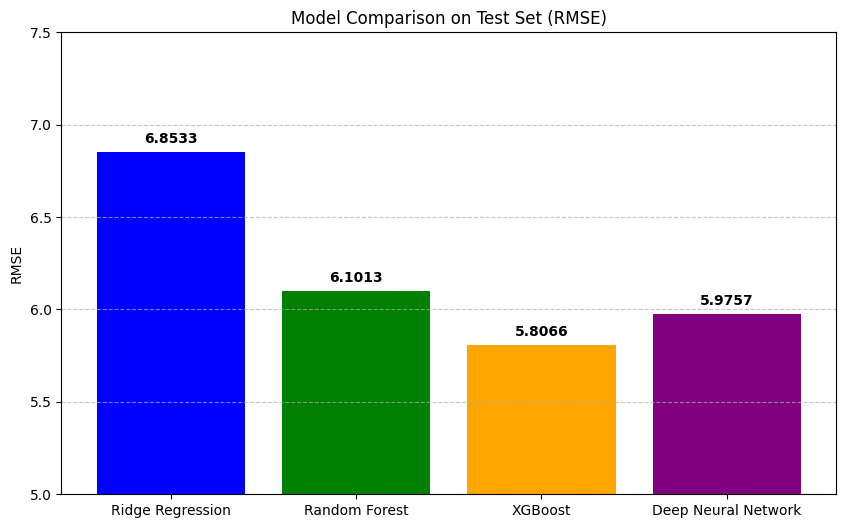

In [ ]:
results = {
    'Model': ['Ridge Regression', 'Random Forest', 'XGBoost', 'Deep Neural Network'],
    'Test RMSE': [test_ridge_rmse, test_rf_rmse, test_xgb_rmse, test_dl_rmse]
}
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Test RMSE'], color=['blue', 'green', 'orange', 'purple'])
plt.ylabel('RMSE')
plt.title('Model Comparison on Test Set (RMSE)')
plt.ylim(5, 7.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(results_df['Test RMSE']):
    plt.text(i, v + 0.05, str(round(v, 4)), ha='center', fontweight='bold')
plt.show()

 Το γραμμικό μοντέλο Ridge παρουσιάζει το μεγαλύτερο RMSE (6.8533). Στο μοντέλο Random Forest το RMSE (6.1013) βελτιώθηκε κατά 11% γεγονός που αποδεικνύει ότι υπάρχουν σύνθετες μη γραμμικές σχέσεις μεταξύ των χαρακτηριστικών και της μεταβλητής στόχου. Οι καλύτερες επιδόσεις επιτεύχθηκαν από το μοντέλο MLP (5.9757) και το μοντέλο XGBoost όπου το RMSE (5.8066) βελτιώθηκε κατά 15% περίπου σε σχέση με το γραμμικό μοντέλο. Το αποτέλεσμα αυτό επιβεβαιώνει τη βιβλιογραφία, σύμφωνα με την οποία οι αλγόριθμοι Gradient Boosting συνήθως υπερτερούν σε δομημένα δεδομένα, καθώς είναι πιο ανθεκτικοί στον θόρυβο και αξιοποιούν αποτελεσματικότερα τα αραιά χαρακτηριστικά που προκύπτουν από την κωδικοποίηση onehot των κατηγορικών χαρακτηριστικών.

#3.6 XGBoost Feature Importance

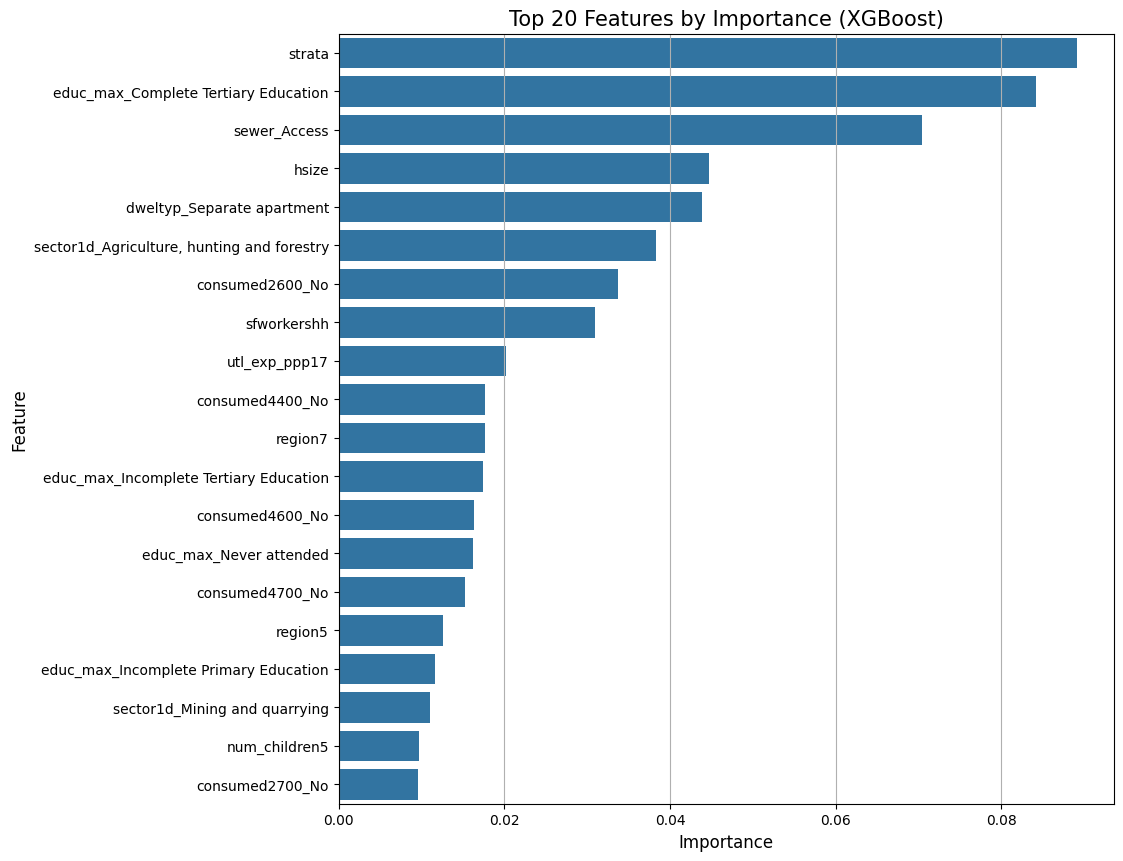

Top 20 Features by Importance (XGBoost)
                                        Feature  Importance
1                                        strata    0.089086
56         educ_max_Complete Tertiary Education    0.084174
29                                 sewer_Access    0.070354
3                                         hsize    0.044678
50                   dweltyp_Separate apartment    0.043837
64   sector1d_Agriculture, hunting and forestry    0.038340
131                             consumed2600_No    0.033660
13                                  sfworkershh    0.030923
2                                 utl_exp_ppp17    0.020151
167                             consumed4400_No    0.017719


In [ ]:
numerical_names = list(numerical_features)
categorical_names = encoder.get_feature_names_out(categorical_features).tolist()
actual_feature_names = numerical_names + categorical_names

feature_importance_df = pd.DataFrame({
    'Feature': actual_feature_names,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Features by Importance (XGBoost)", fontsize=15)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x')
plt.show()

print("Top 20 Features by Importance (XGBoost)")
print(feature_importance_df.head(10))

#4. Official Test Set Preprocessing and Prediction Generation

#4.1 Feature Selection

In [ ]:
test_id = x_test_official[['hhid', 'survey_id']]
x_test_official_final = x_test_official.drop(columns=['hhid', 'survey_id', 'com'])

test_id.shape, x_test_official_final.shape

((103023, 2), (103023, 85))

#4.2 Numerical Ιmputation with Μedian

In [ ]:
x_test_num = num_imputer.transform(x_test_official_final[numerical_features])
x_test_num.shape

(103023, 21)

#4.3 Categorical Ιmputation with Mode

In [ ]:
x_test_cat = cat_imputer.transform(x_test_official_final[categorical_features])
x_test_cat.shape

(103023, 64)

#4.4 Encode Categorical Features

In [ ]:
x_test_cat_encoded = encoder.transform(x_test_cat)
x_test_cat_encoded.shape

(103023, 160)

#4.5 Merge Numerical and Categorical Features


In [ ]:
x_test_processed = np.hstack([x_test_num, x_test_cat_encoded])
x_test_processed.shape

(103023, 181)

#4.6 StandardScaling Normalization

In [ ]:
x_test_scaled = scaler.transform(x_test_processed)
x_test_scaled.shape

(103023, 181)

#4.7 Final Predictions

In [ ]:
final_predictions = best_xgb.predict(x_test_scaled)

#4.8 Submission Files

In [ ]:
submission = test_id.copy()
submission['cons_ppp17'] = final_predictions
submission = submission[['survey_id', 'hhid', 'cons_ppp17']]
submission.to_csv('predicted_household_consumption.csv', index=False)

thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
              9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]

poverty_dist = []

for s_id in submission['survey_id'].unique():
    subset = submission[submission['survey_id'] == s_id]['cons_ppp17']
    row = {'survey_id': s_id}

    for t in thresholds:
        pct = (subset < t).mean()
        row[f'pct_hh_below_{t:.2f}'] = pct

    poverty_dist.append(row)

submission_distribution = pd.DataFrame(poverty_dist)
submission_distribution.to_csv('predicted_poverty_distribution.csv', index=False)

with zipfile.ZipFile('submission.zip', 'w') as f:
    f.write('predicted_household_consumption.csv')
    f.write('predicted_poverty_distribution.csv')

Για την ολοκλήρωση της εργασίας το βέλτιστο μοντέλο XGBoost χρησιμοποιήθηκε για την πρόβλεψη της μεταβλητής στόχου στο αρχείο ελέγχου test_hh_features.csv. Για τον σκοπό αυτό, τα δεδομένα αυτού του αρχείου αρχικά υπόκεινται στην ίδια προεπεξεργασία με τα αρχικά δεδομένα. Στη συνέχεια, το βέλτιστο μοντέλο προβλέπει τη μεταβλητή στόχο. Τα τελικά αποτελέσματα των προβλέψεων αποθηκεύονται στο ζητούμενο αρχείο predicted_household_con-sumption.csv. Παράλληλα, δημιουργείται ακόμα ένα αρχείο (predicted_poverty_ distribution.csv) όπου αποθηκεύεται το ποσοστό των οικογενειών στις οποίες η μεταβλητή στόχος είναι μικρότερη από κάποια συγκεκριμένα όρια σύμφωνα με τις οδηγίες του διαγωνισμού.